In [1]:
import pickle

data_to_load = {
    "X_train": None,
    "X_valid": None,
    "X_test": None,
    "y_train": None,
    "y_valid": None,
    "y_test": None,
    "y_mean": None, 
    "y_std": None,
    "df_test": None
}
for k in data_to_load.keys():
    with open(k + ".pkl", 'rb') as file:
        data_to_load[k] = pickle.load(file)
X_train, X_valid, X_test = data_to_load["X_train"], data_to_load["X_valid"], data_to_load["X_test"]
y_train, y_valid, y_test = data_to_load["y_train"], data_to_load["y_valid"], data_to_load["y_test"]
y_mean, y_std = data_to_load["y_mean"], data_to_load["y_std"]
df_test = data_to_load["df_test"]

In [2]:
shape = X_train.shape[1]

In [3]:
from tensorflow.keras import layers, losses, regularizers, optimizers
import tensorflow as tf

model = tf.keras.Sequential([
    layers.Reshape((-1, shape, )),
    layers.Bidirectional(layers.LSTM(shape, kernel_regularizer=regularizers.l1_l2(l1=1e-6, l2=1e-4))),
    #layers.Dropout(0.2),
    layers.Dense(256, activation="swish", kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)),
    layers.Dropout(0.2),
    layers.Dense(1, kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))
])

model.compile(optimizer=optimizers.Adam(1e-3), loss="mse", metrics=["mae", "mape"])

history = model.fit(
    X_train, y_train, epochs=20, validation_data=(X_valid, y_valid), batch_size=256
)
model.save('bi-lstm')

Epoch 1/20
2353/2353 [==============================] - 31s 12ms/step - loss: 0.9179 - mae: 0.7045 - mape: 575.0535 - val_loss: 0.8974 - val_mae: 0.7065 - val_mape: 821.8427
Epoch 2/20
2353/2353 [==============================] - 28s 12ms/step - loss: 0.8880 - mae: 0.7036 - mape: 408.9274 - val_loss: 0.8961 - val_mae: 0.7071 - val_mape: 718.3347
Epoch 3/20
2353/2353 [==============================] - 28s 12ms/step - loss: 0.8877 - mae: 0.7034 - mape: 368.8418 - val_loss: 0.8970 - val_mae: 0.7073 - val_mape: 733.7349
Epoch 4/20
2353/2353 [==============================] - 29s 12ms/step - loss: 0.8876 - mae: 0.7033 - mape: 586.3966 - val_loss: 0.8970 - val_mae: 0.7082 - val_mape: 619.4686
Epoch 5/20
2353/2353 [==============================] - 29s 12ms/step - loss: 0.8872 - mae: 0.7032 - mape: 416.1011 - val_loss: 0.8959 - val_mae: 0.7076 - val_mape: 733.4044
Epoch 6/20
2353/2353 [==============================] - 29s 12ms/step - loss: 0.8869 - mae: 0.7031 - mape: 513.0178 - val_loss: 0.

INFO:tensorflow:Assets written to: bi-lstm\assets


INFO:tensorflow:Assets written to: bi-lstm\assets


In [4]:
import pandas as pd
import scutquant.scutquant as q

pred = model.predict(X_test)
pred = pd.DataFrame(pred, columns=["predict"], index=X_test.index)
pred["predict"] += y_mean
pred["predict"] *= y_std
pred.describe()

8773/8773 [==============================] - 19s 2ms/step


,predict
count,280721.000000
mean,0.000184
std,0.001574
min,-0.021372
25%,-0.000664
50%,0.000250
75%,0.001099
max,0.011091


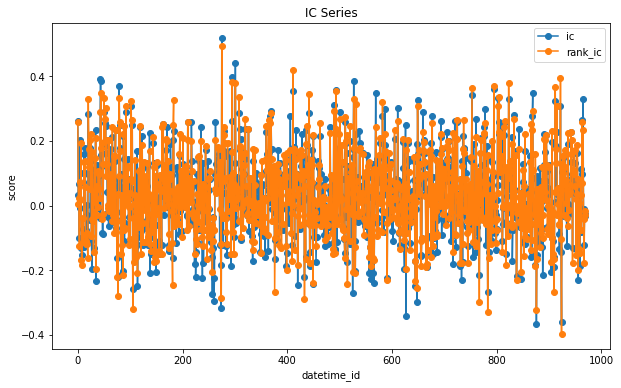

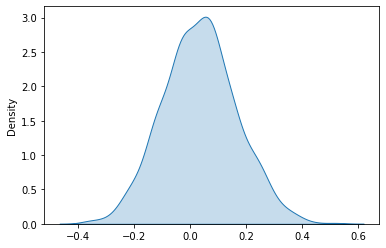

ic= 0.034159952906753735 icir= 0.25928240640266653 rank_ic= 0.03565562460425633 rank_icir= 0.2751311103080666


0.030012107610178904

In [5]:
ic, icir, rank_ic, rank_icir = q.ic_ana(pred["predict"], y_test, groupby='datetime')
print('ic=', ic, 'icir=', icir, 'rank_ic=', rank_ic, 'rank_icir=', rank_icir)
# 使用pearson相关系数评判拟合优度
r = q.pearson_corr(pred["predict"].values, y_test)
r

In [6]:
from scutquant import executor, report

# 将预测值处理成回测需要的格式
pred = executor.prepare(pred, df_test, price='mean_price', volume='vol')

Accuracy of Prediction: 0.5285459936417773


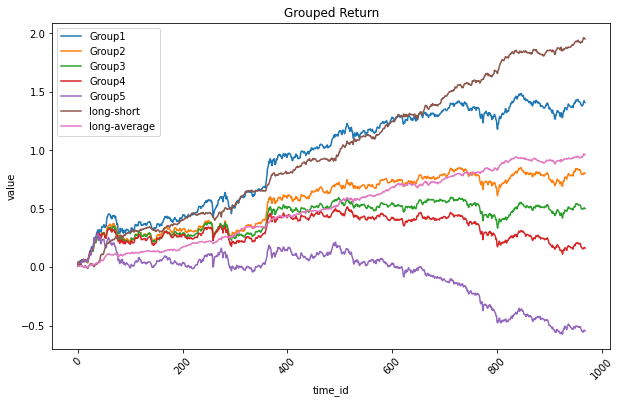

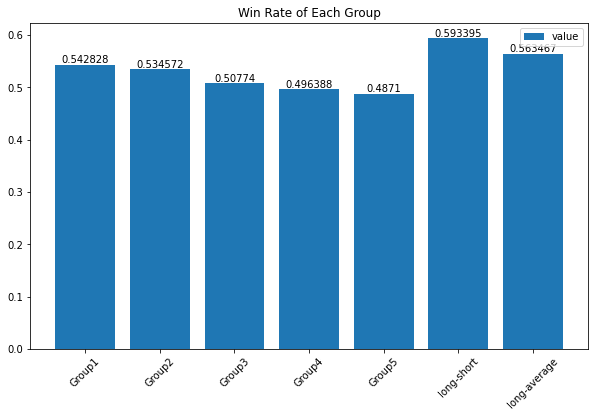

In [7]:
report.group_return_ana(pred, y_test)

In [8]:
backtest = {
    "generator": {
        "mode": "generate"
    },
    "strategy": {
        "class": "SigmaStrategy",  # 做多预测值前20%且值大于0.5%的股票, 做空后20%且值小于0.5%的股票. 自动平仓
        "kwargs": {
            "sigma":1,
            "buy": 0,  
            "sell": -0,
            "auto_offset": False,
            "offset_freq": 2, # 应为delta_t + 1, 例如目标值是close_-2 / close_-1 - 1, 则delta_t = 1
            "buy_only": False,  # =True时，只做多不做空(在A股做空有一定的难度)
            "short_volume": 5000,
            "risk_degree": 0.95,  # 将风险度控制在这个数，如果超过了就按比例减持股票直到风险度小于等于它为止
            "unit": None,  # 由于数据已经是以手为单位, 故无需二次处理
            "max_volume": 0.5  # 手数随可用资金而改变，最大不会超过股票当天成交量的x%(例如T+1时下单，下单手数不会超过T时成交量的x%)
        }
    },
    "account": None,  # 使用默认账户, 即初始资金为1亿, 无底仓
    "trade_params": {
        "cost_buy": 0.0015,  # 佣金加上印花税
        "cost_sell": 0.0005,  
        "min_cost": 5,
    }
}
generator, strategy, account, trade_params = backtest["generator"], backtest["strategy"], backtest["account"], backtest["trade_params"]
exe = executor.Executor(generator, strategy, account, trade_params)
exe.execute(data=pred, verbose=0)

Annualized Return: 0.1873043059619346
Annualized Volatility: 0.6421113735775807
Annualized Return(Benchmark): 0.07899686073853784
Annualized Volatility(Benchmark): 0.3390023870788162 

Cumulative Rate of Return: 0.935124037431379
Cumulative Rate of Return(Benchmark): 0.33958556303554865
Cumulative Excess Rate of Return: 0.5955384743958303 

Max Drawdown: -0.4304273940630494
Max Drawdown(Benchmark): -0.5462600364770351 

Sharpe Ratio: 2.143224423464402
Sortino Ratio: 2.599404594841209
Information Ratio: 0.877468750815162 

Beta: 1.704608093115143
Alpha: -0.004770072509201251
Epsilon: 0.14276919756402134
Profitable Days(%): 0.9545923632610939


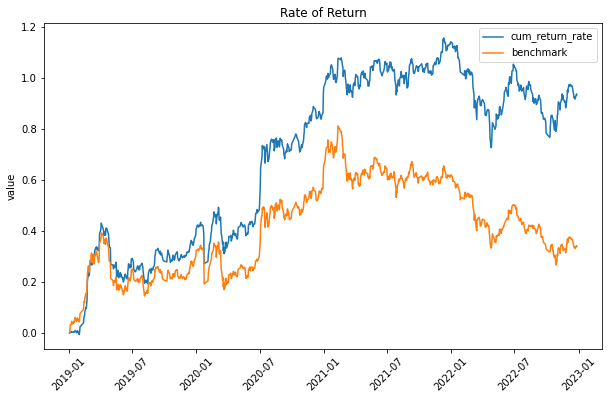

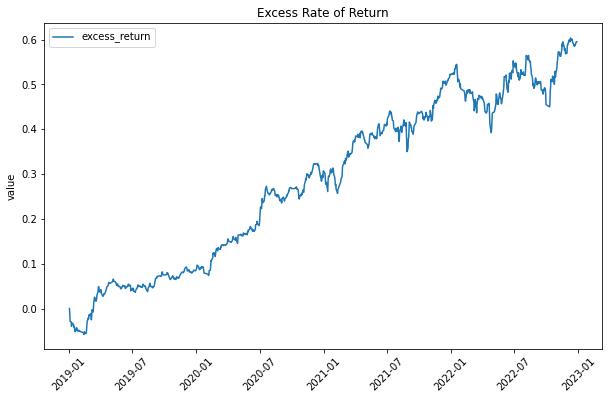

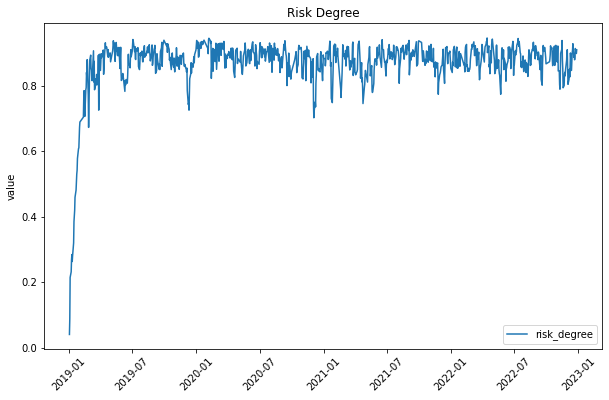

In [9]:
user_account, benchmark = exe.user_account, exe.benchmark
report.report_all(user_account, benchmark, freq=365, time=exe.time)  # 无风险收益率默认为年化3%，可以通过参数rf调节